In [152]:
import numpy as np
import time
import pandas as pd
from scipy import misc
import matplotlib.pyplot as plt
# import tikzplotlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import math
import pandas as pd
# import cvxpy as cp
from scipy.optimize import fsolve
import torch.optim.lr_scheduler as lr_scheduler
import seaborn as sns
torch.set_default_dtype(torch.float64)


In [153]:
M=2000
ite=10
dim_n=3
T=1
T_C=1
T_F=0.1
delta_c = torch.tensor(T_C/ite)
delta_f=torch.tensor(T_F/ite)
print(delta_c,delta_f)
sigma=0.2
mu=0.3
A0=0.0
gamma=0.0
kappa=1.0
rho=5
X0=10000
neuron_model_psi=10

tensor(0.1000) tensor(0.0100)


In [154]:
model_f= torch.nn.Sequential(
    torch.nn.Linear(dim_n, neuron_model_psi),
    torch.nn.ReLU(),
    #torch.nn.Linear(neuron_model_psi, neuron_model_psi),
    #torch.nn.ReLU(),
    # torch.nn.Linear(neuron_model_psi, neuron_model_psi_2),
    # torch.nn.ReLU(),
    torch.nn.Linear(neuron_model_psi, neuron_model_psi),
    torch.nn.ReLU(),
    torch.nn.Linear(neuron_model_psi,1)
)

In [159]:
torch.load('model_N10_Arash.pth').keys()

odict_keys(['linear_stack.0.weight', 'linear_stack.0.bias', 'linear_stack.2.weight', 'linear_stack.2.bias', 'linear_stack.4.weight', 'linear_stack.4.bias'])

In [184]:
class trade_net(nn.Module): #NN for trading strategy
    def __init__(self,params):
        self.dim = params['dim']
        self.num_neurons = params['num_neurons']
        super(trade_net, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(self.dim, self.num_neurons),
            torch.nn.ReLU(),
            nn.Linear(self.num_neurons, self.num_neurons),
            torch.nn.ReLU(),
            nn.Linear(self.num_neurons,1),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits#.reshape([dim,dim])  

In [185]:
#torch.save(model, 'model_N10.pth')
# model_coarse = torch.load('model_N10_best.pth')
# model_coarse = torch.nn.Sequential(
#     torch.nn.Linear(dim_n, 16),
#     torch.nn.ReLU(),
#     torch.nn.Linear(16, 16),
#     torch.nn.ReLU(),
#     torch.nn.Linear(16,1)
# )
model_coarse = torch.load('model_N10_Arash.pth')
model_coarse.eval()

trade_net(
  (linear_stack): Sequential(
    (0): Linear(in_features=3, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

## Value function

In [ ]:
def update(x3,psi,delta):
  t=x3[:,0]+delta
  #print(psi.squeeze(1).shape,x1[:,1].shape)
  D = (x3[:,1]+kappa*psi)*torch.exp(-rho*delta)
  R= x3[:,2]-psi
  #print(R.shape)
  up=torch.cat((t.unsqueeze(1),D.unsqueeze(1),R.unsqueeze(1)),dim=1)
  #print('up shape=', up.shape)
  return up

def loss_func(x2,psi):
  loss=(x2[:,1]*psi+(kappa/2.0)*torch.pow(psi,2))
  return loss

def unit(x1,model,delta):
    psi=model(x1).squeeze(1)
    los=loss_func(x1,psi)
    upd=update(x1,psi,delta)
    #print('unit print=',psi.shape,los.shape,upd.shape)
    return psi,los,upd

def loss_func_total(u,model,delta):
  loss=torch.zeros(M,ite+1)
  psi=torch.zeros(M,ite+1)
  for i in range(ite+1):
    if(i!=ite):
        psi_run,loss_run,u_run=unit(u,model,delta)
        #print('los func=',psi_run.shape,loss_run.shape)
        loss[:,i]=loss_run
        #print(loss)
        psi[:,i]=psi_run
        #print(psi)
        u=u_run
    #print(u)
    else:
    #print(torch.sum(psi,dim=1),R.squeeze(1))
        psi_ter=R.squeeze(1)-torch.sum(psi,dim=1)
        loss_ter=loss_func(u,psi_ter)
      #print('ter',loss_ter.shape)
  #print(torch.sum(loss,dim=1))
  #loss1=torch.sum(loss,dim=1)
  loss1=torch.sum(loss,dim=1)+loss_ter
  #print(loss.shape)
  return torch.mean(loss1)

In [163]:
def testing_coarse(X0,M1):    
    t_test=torch.zeros([M1,1])
    D_test=torch.zeros([M1,1])
    #D_test=torch.FloatTensor(M,1).uniform_(0.1,0.5)   #Price impact D_t
    #R_test=torch.FloatTensor(M1,1).uniform_(50,100)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
    R_test=torch.linspace(X0*0.90, X0*1.1, steps=M1).unsqueeze(1)
    x_test=torch.cat((t_test,D_test,R_test),dim=1)
    #print('Input=',x_test,'\n')
    a=torch.zeros(M1,ite+1)
    #print(a.shape)
    for i in range(ite+1):
      if(i!=ite):
        #print(x_test)
        soln_pred=model_coarse.eval()(x_test).squeeze(1).detach()
        a[:,i]=soln_pred
        x_test=update(x_test,soln_pred,delta_c)
        #print(x_test,'\n')
      else:
        a[:,i]=R_test.squeeze(1)-torch.sum(a,dim=1)

    x1=R_test.squeeze().numpy()
    t_soln=np.zeros((M1,ite+1))
    return x_test,a

In [164]:
def coarse_value(X0,M1):    
    t_test=torch.zeros([M1,1])
    D_test=torch.zeros([M1,1])
    #D_test=torch.FloatTensor(M,1).uniform_(0.1,0.5)   #Price impact D_t
    #R_test=torch.FloatTensor(M1,1).uniform_(50,100)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
    R_test=torch.linspace(X0*0.90, X0*1.1, steps=M1).unsqueeze(1)
    x_test = torch.cat((t_test,D_test,R_test),dim=1)
    x_data = x_test
    #print('Input=',x_test,'\n')
    a=torch.zeros(M1,ite+1)
    #print(a.shape)
    for i in range(ite+1):
      if(i!=ite):
        #print(x_test)
        soln_pred=model_coarse.eval()(x_test).squeeze(1).detach()
        a[:,i]=soln_pred
        x_test=update(x_test,soln_pred,delta_c)
        x_data = torch.cat((x_data,x_test),axis=0)
        #print(x_test,'\n')
      else:
        a[:,i]=R_test.squeeze(1)-torch.sum(a,dim=1)

    # x1=R_test.squeeze().numpy()
    # t_soln=np.zeros((M1,ite+1))
    return x_test,a,x_data

In [181]:
x_c,c_soln,x_data=coarse_value(X0,5)
for x in x_data[-5:][:,0]:
    print("{:.10f}".format(x))

AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

In [166]:
a = torch.tensor(1.0/10.0)
print("{:.10f}, {:.10f}, {:.10f}".format(1.0/10.0, torch.tensor(1.0/10.0), a))

0.1000000000, 0.1000000000, 0.1000000000


In [ ]:
x_c,c_soln=testing_coarse(X0,5)
# print(c_soln.shape)
# print(x_c,c_soln,torch.sum(a,1))
D_max=torch.max(x_c[:,1])
R_min=torch.min(c_soln)
R_max=torch.max(c_soln)
t=torch.zeros([M,1])
D=torch.FloatTensor(M,1).uniform_(0.0,D_max)
#D=torch.FloatTensor(M,1).uniform_(0.1,0.5)   #Price impact D_t
R=torch.FloatTensor(M,1).uniform_(R_min,R_max)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
x=torch.cat((t,D,R),dim=1)
print('coarse soution=',c_soln[0])

coarse soution= tensor([1623.8970,  639.9296,  639.8604,  640.0034,  640.1218,  640.2160,
         640.2860,  641.0455,  642.7218,  631.9081, 1620.0103])


# Training fine model?

In [ ]:
start=time.time()
lr1 = 8e-3
max_epoch = 8000
optimizer = optim.Adam(model_f.parameters(), lr1)
t0 = time.time()
#print(psi.shape)
for epoch in range(max_epoch):
  optimizer.zero_grad()
  cost=loss_func_total(x,model_f,delta_f)
  cost.backward()
  optimizer.step()
  #print(loss.item())
  if (epoch % int(num_epochs/5)== int(num_epochs/5)-1) | (epoch == 0):
    print("At epoch {} the mean cost is {}.  Eproch training time = {:.2E} ms".format(epoch,cost.detach(),1000*(time.time()-t0)))
end=time.time()
print('time elapsed=',end-start)

At epoch 0 the mean error is 1,348,357.7497369533.
At epoch 100 the mean error is 1,318,110.1800272989.
At epoch 200 the mean error is 1,317,993.1381841085.
At epoch 300 the mean error is 1,317,926.592408598.
At epoch 400 the mean error is 1,317,921.1859849205.
At epoch 500 the mean error is 1,317,916.7801129785.
At epoch 600 the mean error is 1,317,905.7003187137.
At epoch 700 the mean error is 1,317,912.942982202.
At epoch 800 the mean error is 1,317,892.0118591327.
At epoch 900 the mean error is 1,317,886.2510973925.
At epoch 1000 the mean error is 1,317,877.0602046344.
At epoch 1100 the mean error is 1,317,875.5395374876.
At epoch 1200 the mean error is 1,317,872.6456064011.
At epoch 1300 the mean error is 1,317,866.1843686597.
At epoch 1400 the mean error is 1,317,863.1316150522.
At epoch 1500 the mean error is 1,317,860.3739151785.
At epoch 1600 the mean error is 1,317,852.9647264066.
At epoch 1700 the mean error is 1,317,877.3527033986.
At epoch 1800 the mean error is 1,317,888.

KeyboardInterrupt: 

In [168]:
torch.save(model_f, 'model_N10_fine.pth')
model_fin = torch.load('model_N10_fine.pth')
model_fin=model_f

In [169]:
def closed_form(X,ite):
  alpa=np.exp(-rho*T/ite)
  p=np.zeros(ite+1)
  p[0]=X/((ite-1)*(1-alpa)+2)
  p[ite]=X/((ite-1)*(1-alpa)+2)
  for j in range(1,ite):
    p[j]=p[0]*(1-alpa)
  return p

def cost(y,ite):
  cost1=0.0
  D1=0.0
  for i in range(ite+1):
    cost1+=D1*y[i]+(kappa/2.0)*np.power(y[i],2)
    D1=(D1+kappa*y[i])*np.exp(-rho*T/ite)
  return cost1

In [170]:
def testing_fine_forward(c_soln,ite):    
    f_soln=[]
    c=c_soln[2]
    x_test=torch.tensor([[0.0,0.0,c[0]]])
    for i in range(ite+1):
        if (i!=0):
            x_test[0,2]=x_test[0,2]+c[i] #Adding previous remaining balance to the current balance
        if (i!=ite):         
            for j in range(ite):
                #print(i,x_test)
                soln_pred=model_fin.eval()(x_test).squeeze(1).detach()
                f_soln.append(soln_pred)
                x_test=update(x_test,soln_pred,delta_f)
            #print(x_test[0,2])
    f_soln.append(x_test[0,2].view(1))
    f_soln= np.array([tensor.numpy() for tensor in f_soln]).reshape(len(f_soln))
    return f_soln


# Results from forward pass

In [171]:
coarse_soln=c_soln[2].numpy()
print('coarse soln',coarse_soln, 'Total=',np.sum(coarse_soln))
fine_soln=testing_fine_forward(c_soln,ite)
true_soln=closed_form(10000,100)
print('\nFine solution=', fine_soln, 'Total=',np.sum(fine_soln))

coarse soln [1804.02877896  710.87052223  710.29798036  710.19455118  710.04228146
  709.84157406  709.59284707  710.06591698  711.54355893  709.08923088
 1804.43275789] Total= 10000.0

Fine solution= [  18.420267     17.63913909   17.27689545   17.22480088   17.20643848
   17.18081488   17.14829047   17.10921164   17.06391126   17.01270921
   23.88222026   23.82248713   23.75433282   23.67819355   23.59448842
   23.50362001   23.40597502   23.30192481   23.19182598   23.24265343
   29.87562403   29.75165776   29.61953308   29.47970399   29.61027853
   30.11694978   30.56335909   30.99834944   31.42189303   31.83396532
   36.07538366   36.62151512   37.15387045   37.67241411   38.1771145
   38.66794391   39.14487848   39.60789821   40.05698694   40.49213227
   44.75334082   45.31760626   45.86566381   46.39749234   46.91307513
   47.41239989   47.89545871   48.56396344   50.11779938   51.58454509
   53.65732472   54.2138487    54.75187727   56.32795232   58.16867572
   59.47406064   60

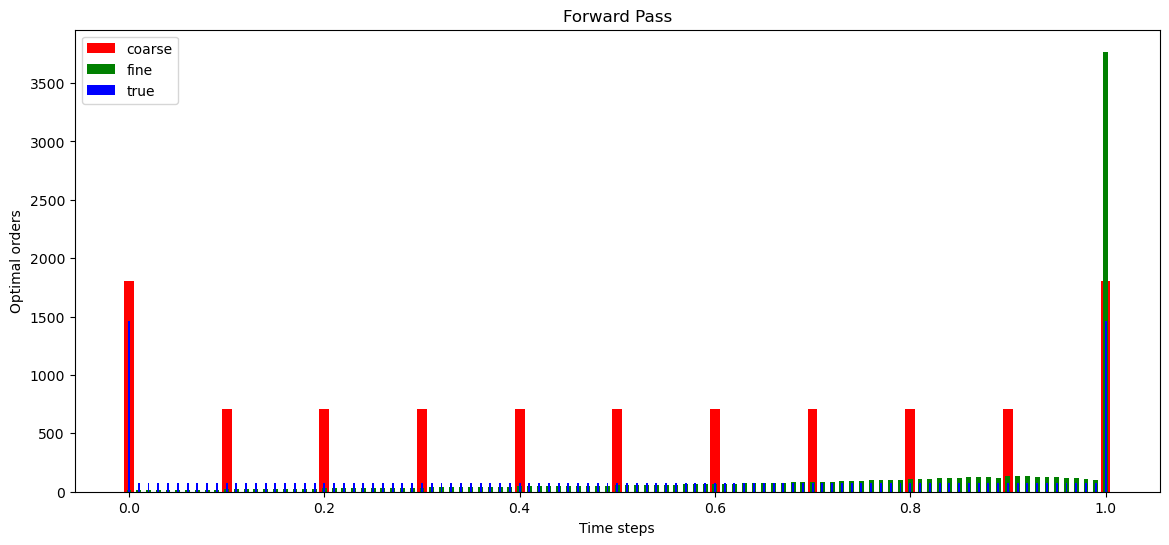

In [172]:
t_step1=np.linspace(0,1,num=11)
t_step2=np.linspace(0,1,num=101)
plt.figure(figsize=(14,6))
plt.bar(t_step1,coarse_soln,color='red',width=0.01,label='coarse')
plt.bar(t_step2,fine_soln,color='green',width=0.005,label='fine')
plt.bar(t_step2,true_soln,color='blue',width=0.002,label='true')
plt.xlabel('Time steps')
plt.ylabel('Optimal orders')
plt.title('Forward Pass')
plt.legend()
plt.show()


In [173]:
# true_cost=cost(true_soln,100)
# fine_cost=cost(fine_soln,100)
# print('True Cost= %0.2f'% true_cost, 'Fine grid cost= %0.2f'% fine_cost)
# error=np.abs(true_cost-fine_cost)
# per_error=100*error/true_cost
# print('Cost Error= %0.2f'% error)
# print('Percentage error= %0.2f'% per_error,'%' )
# D_N=data[0,2].detach().numpy()
# derivative=kappa*(fine_soln[0])-((10000-sum(fine_soln[i] for i in range(len(fine_soln)-1)))+D_N)
# print('\nDerivative of loss with respect to x0 =',derivative)

# Strategy 2 (Adding two consecutive terms to predict the block)

In [174]:
def testing_fine_first_last(c_soln,ite):    
    f_soln=[]
    c=c_soln[2]
    x_test=torch.tensor([[0.0,0.0,c[0]]])
    #x_test[0,2]=x_test[0,2]+c[ite]
    for i in range(ite):       
        x_test[0,2]=x_test[0,2]+c[i+1] #Adding previous remaining balance to the current balance         
        for j in range(ite):
            #print(i,x_test)
            soln_pred=model_fin.eval()(x_test).squeeze(1).detach()
            f_soln.append(soln_pred)
            x_test=update(x_test,soln_pred,delta_f)
            #print(x_test[0,2])
    f_soln.append(x_test[0,2].view(1))
    f_soln= np.array([tensor.numpy() for tensor in f_soln]).reshape(len(f_soln))
    return f_soln

In [175]:
# fine_soln=testing_fine_first_last(c_soln,ite)
# true_soln=closed_form(10000,100)
# print('\nFine solution=', fine_soln, fine_soln.shape,'Total=',np.sum(fine_soln))
# print('\nDifference between true and fine=',(fine_soln-true_soln))
# D_N=data[0,2].detach().numpy()
# derivative=kappa*(fine_soln[0])-((10000-sum(fine_soln[i] for i in range(len(fine_soln)-1)))+D_N)
# print('\nDerivative of loss with respect to x0 =',derivative)

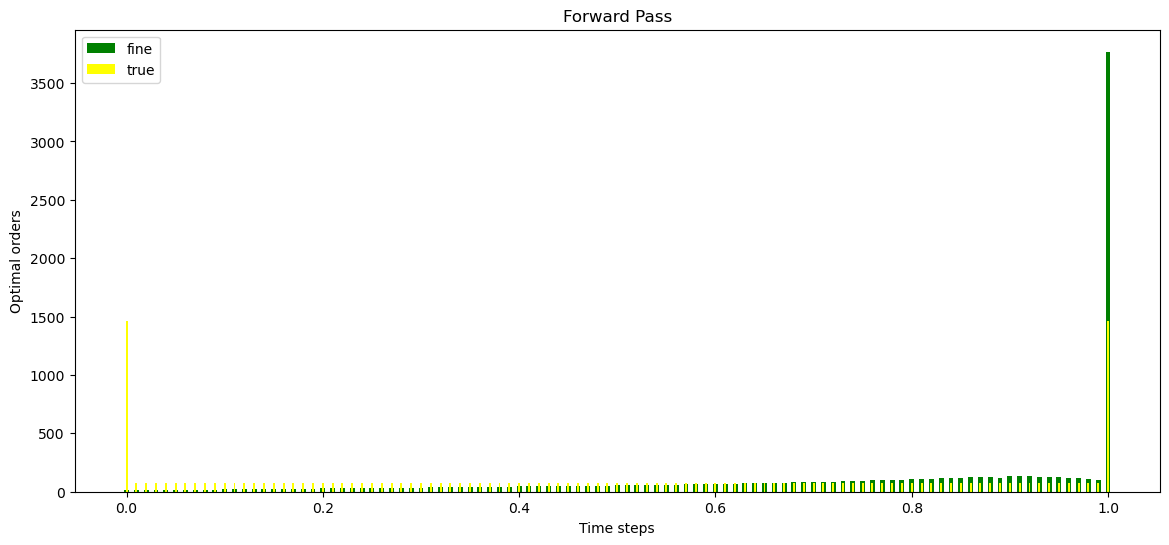

In [176]:
t_step1=np.linspace(0,1,num=11)
t_step2=np.linspace(0,1,num=101)
plt.figure(figsize=(14,6))
#plt.bar(t_step1,coarse_soln,color='red',width=0.01,label='coarse')
plt.bar(t_step2,fine_soln,color='green',width=0.005,label='fine')
plt.bar(t_step2,true_soln,color='yellow',width=0.002,label='true')
plt.xlabel('Time steps')
plt.ylabel('Optimal orders')
plt.title('Forward Pass')
plt.legend()
plt.show()

In [177]:
# true_cost=cost(true_soln,100)
# fine_cost=cost(fine_soln,100)
# print('True Cost= %0.2f'% true_cost, 'Fine grid cost= %0.2f'% fine_cost)
# error=np.abs(true_cost-fine_cost)
# per_error=100*error/true_cost
# print('Cost Error= %0.2f'% error)
# print('Percentage error= %0.2f'% per_error,'%' )
# D_N=data[0,2].detach().numpy()
# derivative=kappa*(fine_soln[0])-((10000-sum(fine_soln[i] for i in range(len(fine_soln)-1)))+D_N)
# print('\nDerivative of loss with respect to x0 =',derivative)

# Strategy 3: Updated (Adding First and last balance and then doing the forward pass)

In [178]:
def testing_fine_first_last(c_soln,ite):    
    f_soln=[]
    c=c_soln[2]
    x_test=torch.tensor([[0.0,0.0,c[0]]])
    x_test[0,2]=x_test[0,2]+c[ite]
    for i in range(ite):       
        if (i!=0):
            x_test[0,2]=x_test[0,2]+c[i] #Adding previous remaining balance to the current balance         
        for j in range(ite):
            #print(i,x_test)
            soln_pred=model_fin.eval()(x_test).squeeze(1).detach()
            f_soln.append(soln_pred)
            x_test=update(x_test,soln_pred,delta_f)
            #print(x_test[0,2])
    f_soln.append(x_test[0,2].view(1))
    f_soln= np.array([tensor.numpy() for tensor in f_soln]).reshape(len(f_soln))
    return x_test,f_soln

In [179]:
data,fine_soln=testing_fine_first_last(c_soln,ite)
D_N=data[0,2].detach().numpy()
derivative_fin=kappa*(fine_soln[0])-((10000-sum(fine_soln[i] for i in range(len(fine_soln)-1)))+D_N)
derivative_true=kappa*(true_soln[0])-((10000-sum(true_soln[i] for i in range(len(true_soln)-1)))+D_N)
print('\nDerivative of loss func with respect to x0 (True soln) =',derivative_true)
print('\nDerivative of loss func with respect to x0 (Fine soln) =',derivative_fin)
true_soln=closed_form(10000,100)
print('\nFine solution=', fine_soln,'Total=',np.sum(fine_soln))
print('\nTrue solution=', true_soln,'Total=',np.sum(true_soln))
print('\nDifference between true and fine=',(fine_soln-true_soln))



Derivative of loss func with respect to x0 (True soln) = -1572.6418137284252

Derivative of loss func with respect to x0 (Fine soln) = -3108.070087547819

Fine solution= [  37.21353991   35.64626718   34.91348926   34.79781531   34.75998442
   34.70748464   34.64104434   34.56136361   34.46911524   34.36494575
   41.17578375   41.05197341   40.91462737   40.76445997   40.60215741
   40.42837876   40.24375692   40.0488996    40.72683417   41.34675439
   46.32981408   46.42088074   47.28212759   47.99180787   48.68346773
   49.35706195   50.01255041   50.64989809   51.26907499   51.87005616
   56.29366034   57.01525774   57.71636398   58.39695014   59.05699296
   59.69647477   60.31538344   60.91371239   62.73298324   64.75303268
   66.58380834   67.25460044   68.83805744   71.08366235   72.84388275
   74.45133671   76.07426689   77.7249807    79.40393616   81.11159878
   83.5518459    85.36623692   87.21166852   89.08865234   90.99770843
   93.0675238    95.34059748   97.67467121  100.

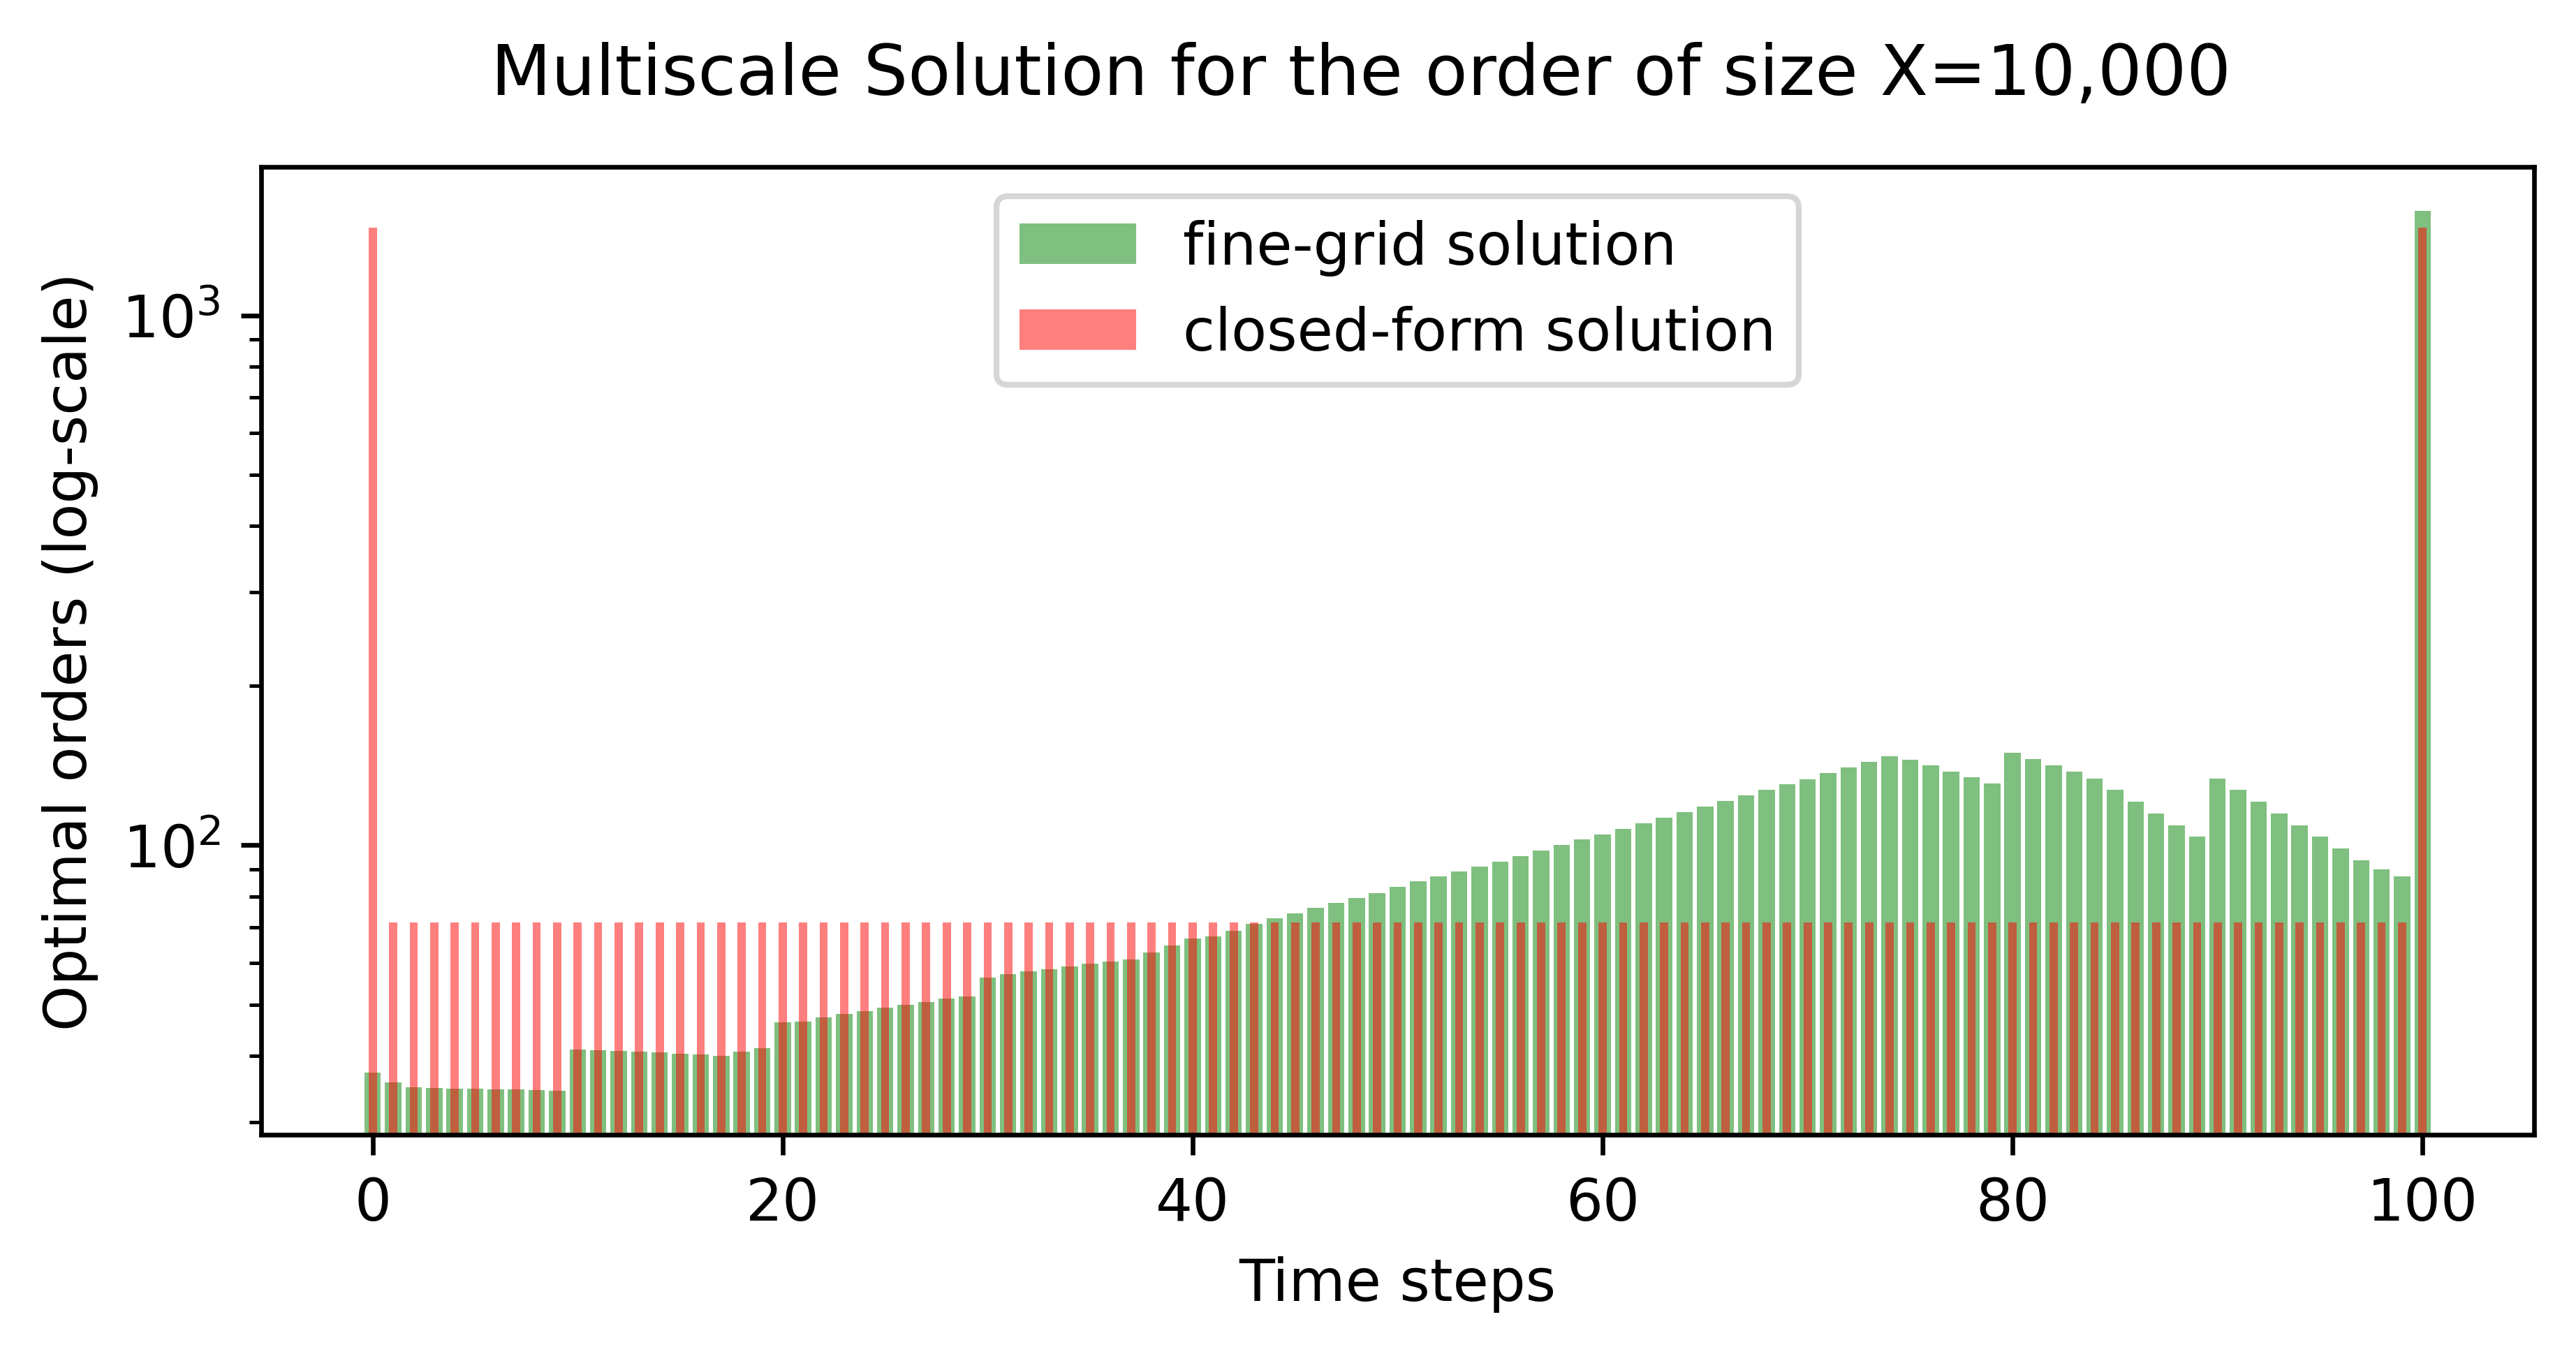

In [180]:
t_step1=np.linspace(0,1,num=11)
t_step2=np.linspace(0,100,num=101)
name='N10_T1_K1_rho5_neo20.eps'
f, ax = plt.subplots(figsize=(7,3),dpi=600)
#plt.bar(t_step1,coarse_soln,color='red',width=0.01,label='coarse')
ax.bar(t_step2,fine_soln,color='green',width=0.8,label='fine-grid solution',alpha=0.5)
ax.bar(t_step2,true_soln,color='red',width=0.4,label='closed-form solution',alpha=0.5)
ax.set_xlabel('Time steps')
ax.set_ylabel('Optimal orders (log-scale)')
f.suptitle('Multiscale Solution for the order of size X={:,}'.format(X0))
ax.legend()
# plt.savefig(name,format='eps')  
ax.set_yscale('log')
# plt.show()
# tikzplotlib.save("LOB_Linear.tex")

In [ ]:
true_cost=cost(true_soln,100)
fine_cost=cost(fine_soln,100)
print('True Cost= %0.2f'% true_cost, 'Fine grid cost= %0.2f'% fine_cost)
error=np.abs(true_cost-fine_cost)
per_error=100*error/true_cost
print('Cost Error = %0.2f'% error)
print('Percentage Error = %0.2f'% per_error,'%')

True Cost= 14287839.92 Fine grid cost= 14317871.96
Cost Error = 30032.04
Percentage Error = 0.21 %


# The derivative of the loss function

In [ ]:
# The derivative of the loss function with respect to x0 = kappa*x0-[kappa(X-(x0+x1+......+x_{N-1})+DN)]
# 